In [973]:
from networkx.algorithms.shortest_paths import weighted
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd

# Creamos el grafo
G = nx.Graph()

# Agregamos los nodos
G.add_nodes_from(["London", "Paris", "Madrid", "Brussels", "Lyon", "Barcelona", "Amsterdam", "Cologne", "Berlin", "Frankfurt", "Mylan", "Rome"])

# Agregamos las aristas ponderadas con dos valores distintos
G.add_edge("London", "Paris", costo=98, tiempo=136)
G.add_edge("London", "Brussels", costo=98, tiempo=136)

G.add_edge("Paris", "Brussels", costo=80, tiempo=82)
G.add_edge("Paris", "Frankfurt", costo=345, tiempo=480)
G.add_edge("Paris", "Lyon", costo=185, tiempo=112)
G.add_edge("Paris", "Barcelona", costo=400, tiempo=390)
G.add_edge("Paris", "Madrid", costo=380, tiempo=225)
G.add_edge("Madrid","Barcelona",  costo=98, tiempo=150)
G.add_edge("Barcelona", "Lyon", costo=320, tiempo=200)
G.add_edge("Lyon","Mylan",  costo=180, tiempo=176)
G.add_edge("Mylan", "Frankfurt", costo=240, tiempo=454)
G.add_edge("Mylan", "Rome", costo=125, tiempo=168)
G.add_edge("Frankfurt","Berlin",  costo=125, tiempo=232)
G.add_edge("Frankfurt","Cologne",  costo=40, tiempo=120)
G.add_edge("Cologne","Amsterdam",  costo=40, tiempo=120)
G.add_edge("Amsterdam", "Berlin", costo=235, tiempo=364)
G.add_edge("Amsterdam", "Brussels", costo=48, tiempo=105)

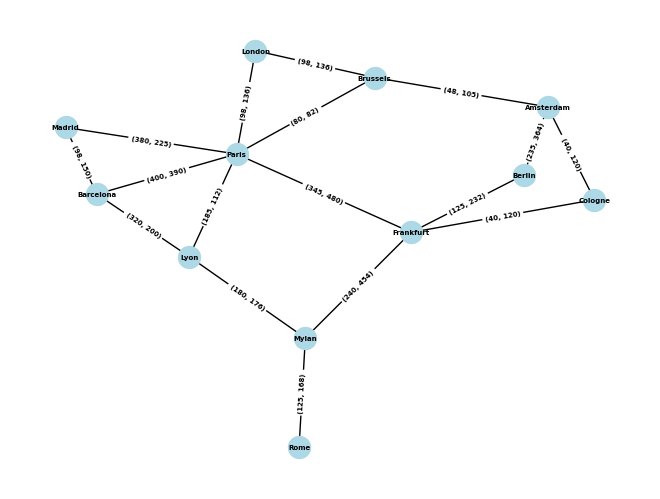

In [990]:
# Dibujamos el grafo
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', font_weight='bold', font_size=5, node_size=250)
labels = nx.get_edge_attributes(G, 'costo')  # Obtenemos solo el valor de costo
for key in nx.get_edge_attributes(G, 'costo'):  # Recorremos el diccionario de atributos para obtener ambos valores
    labels[key] = (labels[key], nx.get_edge_attributes(G, 'tiempo')[key])
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=5, font_weight='bold')
plt.show()

In [975]:
def generate_random_path():
    # Start at a random node
    current_node = random.choice(list(G.nodes()))

    # Initialize the path, time and cost
    path = [current_node]
    time = 0
    cost = 0

    # Traverse the graph until the time constraint is met or no more neighbors are available
    unique = 0
    while time < 4320:
      # Get the neighbors of the current node
      neighbors = list(G[current_node])

      # Remove any neighbors that have already been visited
      unvisited_neighbors = [n for n in neighbors if n not in path]
      if not unvisited_neighbors:
          break

      # Choose a random unvisited neighbor
      next_node = random.choice(unvisited_neighbors)

      # Update the path, time and cost
      path.append(next_node)
      edge = G[current_node][next_node]
      time += edge['tiempo']
      cost += edge['costo']
      
      # Move to the next node
      current_node = next_node


    return path, time, cost

In [976]:
def path_fitness(path):

    for i in range(len(path)-1):
      try:
        edge = G[path[i]][path[i+1]]
      except:
        return 0

    # Calculate the sum of the cost of the path
    cost = 1/sum(G[path[i]][path[i+1]]['costo'] for i in range(len(path)-1))
    
    # Calculate the number of unique nodes in the path
    unique_nodes = len(set(path))


    # Return the sum of the cost and the number of unique nodes
    return cost + unique_nodes

In [977]:
# Create an individual path
def create_individual():
    path, time, cost = generate_random_path()
    fitness = path_fitness(path)
    path_dict = {'path': path, 'tiempo': time, 'costo': cost, 'fitness': fitness}
    
    return path_dict

In [978]:
# Create the first generation of paths
def firstGeneration(genSize):
  population = []
  for i in range(genSize):
      path = create_individual()
      population.append(path)
  return population

In [979]:
# Find the two best paths with the highest fitness scores
def sorting_gen(paths):
    # Sort the paths based on their fitness scores
    sorted_paths = sorted(paths, key=lambda x: x['fitness'], reverse = True)

    # Return the list of best paths
    return sorted_paths

In [980]:
def calculate_time_and_cost(path):
    total_time = 0
    total_cost = 0
    for i in range(len(path)-1):

      try:
        edge = G[path[i]][path[i+1]]
      except:
        return 0, 0

      total_time += edge['tiempo']
      total_cost += edge['costo']
      
    return total_time, total_cost

In [981]:
def single_point_crossover(path_1, path_2):
    
    # Choose a random crossover point
    crossover_point = random.randint(1, len(path_1) - 1)
    
    # Create the new paths by swapping the tails of the paths
    new_path_1 = path_1['path'][:crossover_point] + path_2['path'][crossover_point:]
    new_path_2 = path_2['path'][:crossover_point] + path_1['path'][crossover_point:]
    
    # Create the new individuals with the new paths
    new_individual_1 = {'path': new_path_1, 'tiempo': 0, 'costo': 0, 'fitness': 0}
    new_individual_2 = {'path': new_path_2, 'tiempo': 0, 'costo': 0, 'fitness': 0}
    
    # Calculate the time and cost for the new individuals
    new_individual_1['tiempo'], new_individual_1['costo'] = calculate_time_and_cost(new_path_1)
    new_individual_2['tiempo'], new_individual_2['costo'] = calculate_time_and_cost(new_path_2)
    
    # Calculate the fitness for the new individuals
    new_individual_1['fitness'] = path_fitness(new_path_1)
    new_individual_2['fitness'] = path_fitness(new_path_2)
    
    return new_individual_1, new_individual_2


In [982]:
# Creating the next generation + best individuals from previous generation
def breedPopulation(matingpool, eliteSize):
    nextGen = []
    new_children = len(matingpool) - eliteSize

    for i in range (0, eliteSize):
      nextGen.append(matingpool[i])

    for i in range(0, new_children, 2):
      child1, child2 = single_point_crossover(matingpool[i], matingpool[i+1])

      if child1['fitness'] != 0:
        nextGen.append(child1)
      
      if child2['fitness'] != 0:
        nextGen.append(child2)
    
    return nextGen

In [983]:
def mutateIndividual(path, mutation_rate):
    mutated = path
    if random.uniform(0, 1) < mutation_rate:
        # Choose two random positions in the chromosome
        position1 = random.randint(0, len(path['path']) - 1)
        position2 = random.randint(0, len(path['path']) - 1)

        # Clear variable
        mutated['tiempo'] = 0
        mutated['costo'] = 0
        mutated['fitness'] = 0

        # Swap the cities at the chosen positions
        path['path'][position1], path['path'][position2] = path['path'][position2], path['path'][position1]
    
        # Calculate the time and cost for the new individuals
        mutated['time'], mutated['cost'] = calculate_time_and_cost(path)
        
        # Calculate the fitness for the new individuals
        mutated['fitness'] = path_fitness(mutated)
        mutated['fitness'] = path_fitness(mutated)
    return mutated

In [984]:
def mutatePopulation(generation, mutationRate):
  mutatedGen = []

  for i in range(0, len(generation)):
    mutatedIndividual = mutateIndividual(generation[i], mutationRate)
    mutatedGen.append(mutatedIndividual)

  return mutatedGen

In [985]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    genRanked = sorting_gen(currentGen)
    children = breedPopulation(genRanked, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

In [986]:
def geneticAlgorithm(popSize, eliteSize, mutationRate, generations):
    pop = firstGeneration(popSize)
    print("Initial fitness: " + str(sorting_gen(pop)[0]['fitness']))
    
    gen_data = []  # Lista para almacenar los datos de cada generación
    
    for i in range(generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        best_fitness = sorting_gen(pop)[0]['fitness']
        best_route = sorting_gen(pop)[0]['path']
        best_cost = sorting_gen(pop)[0]['costo']
        
        # Agregar los datos de la generación actual a la lista gen_data
        gen_data.append({'generation': i+1, 'fitness': best_fitness, 'path': best_route, 'costo': best_cost})
        
        print("Fitness from generation ", str(i+1), ": ", str(best_fitness))
      
    bestRoute = sorting_gen(pop)[0]
    

    return bestRoute



In [987]:
solution = geneticAlgorithm(popSize = 100, eliteSize = 20, mutationRate = 0.1, generations = 50)
print("Final fitness: " + str(solution['fitness']))
print("Path: " + str(solution['path']))
print("Costo: " + str(solution['costo']))

Initial fitness: 11.00067842605156
Fitness from generation  1 :  11.00067842605156
Fitness from generation  2 :  11.00067842605156
Fitness from generation  3 :  11.00067842605156
Fitness from generation  4 :  11.00067842605156
Fitness from generation  5 :  11.00067842605156
Fitness from generation  6 :  11.00067842605156
Fitness from generation  7 :  11.00067842605156
Fitness from generation  8 :  11.00067842605156
Fitness from generation  9 :  11.00067842605156
Fitness from generation  10 :  11.00067842605156
Fitness from generation  11 :  11.00067842605156
Fitness from generation  12 :  11.00067842605156
Fitness from generation  13 :  11.00067842605156
Fitness from generation  14 :  11.00067842605156
Fitness from generation  15 :  11.00067842605156
Fitness from generation  16 :  11.00067842605156
Fitness from generation  17 :  11.00067842605156
Fitness from generation  18 :  11.00067842605156
Fitness from generation  19 :  11.00067842605156
Fitness from generation  20 :  11.000678426